In [2]:
# Gerekli kütüphaneleri içe aktar
from io import open
import unicodedata
import string
import re
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter 
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import pickle
import spacy

C:\Users\VuralBayrakli\anaconda3\envs\env\lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\VuralBayrakli\anaconda3\envs\env\lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [3]:
# 'tur-eng/tur.txt' dosyasını 'utf-8' kodlamasıyla aç
with open('tur-eng/tur.txt', encoding='utf-8') as f:
    # Dosyayı oku, boşlukları temizle ve satırlara ayır
    lines = f.read().strip().split('\n')

# Toplam çift sayısını yazdır
print(f"{len(lines):,} English-Turkish phrase pairs.\n")

# Rastgele seçilmiş 5 örneği göster
print("~~~~~ Examples: ~~~~~")
for example in random.choices(lines, k=5):
    # Örneği İngilizce ve Türkçe cümle olarak ayır
    pair = example.split('\t')
    print(f"English:  {pair[0]}")
    print(f"Turkish:  {pair[1]}")
    print()

141,847 English-Turkish phrase pairs.

~~~~~ Examples: ~~~~~
English:  Go and talk to her, Tom. What are you afraid of?
turkish:   Git ve onunla konuş Tom . Neyden korkuyorsun?

English:  Our electric heater does not work well.
turkish:   Elektrikli ısıtıcımız iyi çalışmıyor.

English:  Can't we start again?
turkish:   Yeniden başlayamaz mıyız?

English:  It isn't likely Tom will come.
turkish:   Tom'un gelmesi pek olası değil.

English:  What is the meaning of that word?
turkish:   O sözcüğün anlamı nedir?



In [2]:
# gRPC üzerinden Zemberek dil işleme servislerini kullanmak için gerekli modülleri ve paketleri içe aktar
import sys
import grpc
import zemberek_grpc.language_id_pb2 as z_langid
import zemberek_grpc.language_id_pb2_grpc as z_langid_g
import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g
import zemberek_grpc.preprocess_pb2 as z_preprocess
import zemberek_grpc.preprocess_pb2_grpc as z_preprocess_g
import zemberek_grpc.morphology_pb2 as z_morphology
import zemberek_grpc.morphology_pb2_grpc as z_morphology_g

# gRPC kanalını belirtilen adres ve port üzerinden oluştur
channel = grpc.insecure_channel('localhost:6789')

# Dil tespiti için servis istemcisini oluştur
langid_stub = z_langid_g.LanguageIdServiceStub(channel)

# Normalizasyon için servis istemcisini oluştur
normalization_stub = z_normalization_g.NormalizationServiceStub(channel)

# Metin ön işleme için servis istemcisini oluştur
preprocess_stub = z_preprocess_g.PreprocessingServiceStub(channel)

# Morfoloji analizi için servis istemcisini oluştur
morphology_stub = z_morphology_g.MorphologyServiceStub(channel)

# Dil tespiti fonksiyonu
def find_lang_id(i):
    response = langid_stub.Detect(z_langid.LanguageIdRequest(input=i))
    return response.langId

# Metni token'lara ayıran fonksiyon
def tokenize(i):
    response = preprocess_stub.Tokenize(z_preprocess.TokenizationRequest(input=i))
    return response.tokens

# Decode işlemini gerçekleştiren fonksiyon
def fix_decode(text):
    """Pass decode."""
    if sys.version_info < (3, 0):
        return text.decode('utf-8')
    else:
        return text
    
# Morfoloji analizi fonksiyonu
def analyze(i):
    response = morphology_stub.AnalyzeSentence(z_morphology.SentenceAnalysisRequest(input=i))
    return response;


In [3]:
# Metni normalize etmek için bir fonksiyon
def normalizeString(s):
    # Metni düşük harfe dönüştür, Türkçe karakterleri ve belirli noktalama işaretlerini koru
    s = s.lower().strip()
    # Sadece harfler, nokta (.), soru işareti (?), ünlem işareti (!) ve Türkçe karakterleri koru
    s = re.sub(r"[^a-zçğıöşü.!?]+", " ", s)
    return s

# Belirli kriterlere göre çiftleri filtrelemek için bir fonksiyon
def filterPair(p, max_length, prefixes):
    # Her iki cümle de belirtilen maksimum uzunluktan daha kısa mı kontrol et
    good_length = (len(p[0].split(' ')) < max_length) and (len(p[1].split(' ')) < max_length)
    # Eğer önekler belirtilmişse, cümlenin önek ile başlayıp başlamadığını kontrol et
    if len(prefixes) == 0:
        return good_length
    else:
        return good_length and p[0].startswith(prefixes)

# Belirli kriterlere göre çiftleri filtrelemek için bir fonksiyon
def filterPairs(pairs, max_length, prefixes=()):
    return [pair for pair in pairs if filterPair(pair, max_length, prefixes)]

# Veriyi hazırlamak için bir fonksiyon
def prepareData(lines, filter=False, reverse=False, max_length=10, prefixes=()):
    # Her bir satırı normalize et ve çiftlere ayır
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    print(f"Given {len(pairs):,} sentence pairs.")

    # Eğer filtreleme etkinse, çiftleri belirtilen kriterlere göre filtrele
    if filter:
        pairs = filterPairs(pairs, max_length=max_length, prefixes=prefixes)
        print(f"After filtering, {len(pairs):,} remain.")

    return pairs


In [139]:
basic_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    'are you', 'am i ', 
    'were you', 'was i ', 
    'where are', 'where is',
    'what is', 'what are'
)

In [140]:
pairs = prepareData(lines, 
                    filter=True, 
                    max_length=MAX_SENTENCE_LENGTH, 
                    prefixes=basic_prefixes if FILTER_TO_BASIC_PREFIXES else ())

Given 141,847 sentence pairs.
After filtering, 141,775 remain.


In [141]:
formatted_pairs = [(pair[0], pair[1]) for pair in pairs]

In [144]:
formatted_pairs

[('hi.', 'merhaba.'),
 ('run!', 'kaç!'),
 ('run!', 'koş!'),
 ('run.', 'kaç!'),
 ('run.', 'koş!'),
 ('who?', 'kim?'),
 ('wow!', 'vay canına!'),
 ('duck!', 'ördek!'),
 ('fire!', 'ateş!'),
 ('fire!', 'yangın!'),
 ('fire!', 'ateş et!'),
 ('help!', 'i mdat!'),
 ('jump!', 'atla!'),
 ('jump.', 'git!'),
 ('jump.', 'atla!'),
 ('stay.', 'kal.'),
 ('wait.', 'bekle.'),
 ('do it.', 'onu yap.'),
 ('go on.', 'devam edin!'),
 ('hello.', 'merhaba.'),
 ('i ran.', 'koştum.'),
 ('i see.', 'anlıyorum.'),
 ('i see.', 'görüyorum.'),
 ('oh no!', 'oh hayır!'),
 ('shoot!', 'ateş!'),
 ('shoot!', 'ateş et!'),
 ('shoot!', 'vur!'),
 ('attack!', 'saldır!'),
 ('attack!', 'hücum!'),
 ('cheers!', 'yarasın!'),
 ('cheers!', 'şerefe.'),
 ('exhale.', 'soluk ver.'),
 ('freeze!', 'kımıldama!'),
 ('freeze!', 'olduğun yerde kal!'),
 ('go now.', 'haydi git.'),
 ('go now.', 'git artık.'),
 ('go now.', 'gidin artık.'),
 ('got it?', 'anladın mı?'),
 ('i pass.', 'ben yokum.'),
 ('i pass.', 'pas geçiyorum.'),
 ('i m .', 'ben yaşında

In [3]:
# İngilizce dil modelini yükleme
en_nlp = spacy.load("en_core_web_sm")

# İngilizce cümleleri token'lara ayıran fonksiyon
def tokenize_en(text):
    return [tok.text for tok in en_nlp.tokenizer(text)]

# Türkçe cümleleri token'lara ayıran fonksiyon
def tokenize_tr(sentence):
    liste = []
    # Zemberek dil işleme servisini kullanarak Türkçe cümleyi analiz etme
    analysis_result = analyze(sentence)
    for a in analysis_result.results:
        best = a.best
        lemmas = ""
        liste.append(a.token)
    
    return liste

In [154]:
# İngilizce ve Türkçe kelimeleri saymak için sayaçlar oluştur
en_counter = Counter()
tr_counter = Counter()

# Rastgele seçilmiş 5 çift üzerinde işlem yap
for eng, tur in random.choices(formatted_pairs, k=5):
    # İngilizce cümleyi ekrana yazdır
    print(f"English:  {eng}")
    # İngilizce cümleyi token'lara ayır ve ekrana yazdır
    print(tokenize_en(eng))
    # Türkçe cümleyi ekrana yazdır
    print(f"Turkish:  {tur}")
    # Türkçe cümleyi token'lara ayır ve ekrana yazdır
    aa = tokenize_tr(tur)
    print(aa)
    print()

    # İngilizce kelimeleri say
    en_counter.update(tokenize_en(eng))
    # Türkçe kelimeleri say
    tr_counter.update(aa)

English:  i don t have time to help tom.
['i', 'don', 't', 'have', 'time', 'to', 'help', 'tom', '.']
turkish:   tom a yardım edecek zamanım yok.
['tom', 'a', 'yardım', 'edecek', 'zamanım', 'yok', '.']

English:  tom dreamed about mary.
['tom', 'dreamed', 'about', 'mary', '.']
turkish:   tom rüyasında mary yi gördü.
['tom', 'rüyasında', 'mary', 'yi', 'gördü', '.']

English:  i tried to keep my balance.
['i', 'tried', 'to', 'keep', 'my', 'balance', '.']
turkish:   dengemi korumayı denedim.
['dengemi', 'korumayı', 'denedim', '.']

English:  this is the tricky part.
['this', 'is', 'the', 'tricky', 'part', '.']
turkish:   i şin zor kısmı bu.
['i', 'şin', 'zor', 'kısmı', 'bu', '.']

English:  tom kept a straight face.
['tom', 'kept', 'a', 'straight', 'face', '.']
turkish:   tom ciddiyetini bozmadı.
['tom', 'ciddiyetini', 'bozmadı', '.']



In [155]:
# Özel token'ları tanımla
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

# İngilizce ve Türkçe cümle listeleri
en_list = []
tr_list = []

# İngilizce ve Türkçe kelime sayaçları
en_counter = Counter()
tr_counter = Counter()

# İngilizce ve Türkçe cümle uzunlukları
en_lengths = []
tr_lengths = []

# Tokenleme işlemi
sayac = 0
for en, tr in formatted_pairs:
    # İngilizce ve Türkçe cümleleri token'lara ayır
    en_toks = tokenize_en(en)
    tr_toks = tokenize_tr(tr)
    
    # Token'ları ilgili listelere ekle
    en_list += [en_toks]
    tr_list += [tr_toks]
    
    # Kelime sayılarını güncelle
    en_counter.update(en_toks)
    tr_counter.update(tr_toks)
    
    # Cümle uzunluklarını kaydet
    en_lengths.append(len(en_toks))
    tr_lengths.append(len(tr_toks))
    
    sayac += 1
    
    # Her 1000 çift için ilerlemeyi ekrana yazdır
    if sayac % 1000 == 0:
        print(sayac)

# İngilizce ve Türkçe kelime dağarcıklarını oluştur
en_vocab = build_vocab_from_iterator(en_list, specials=SPECIALS)
tr_vocab = build_vocab_from_iterator(tr_list, specials=SPECIALS)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000


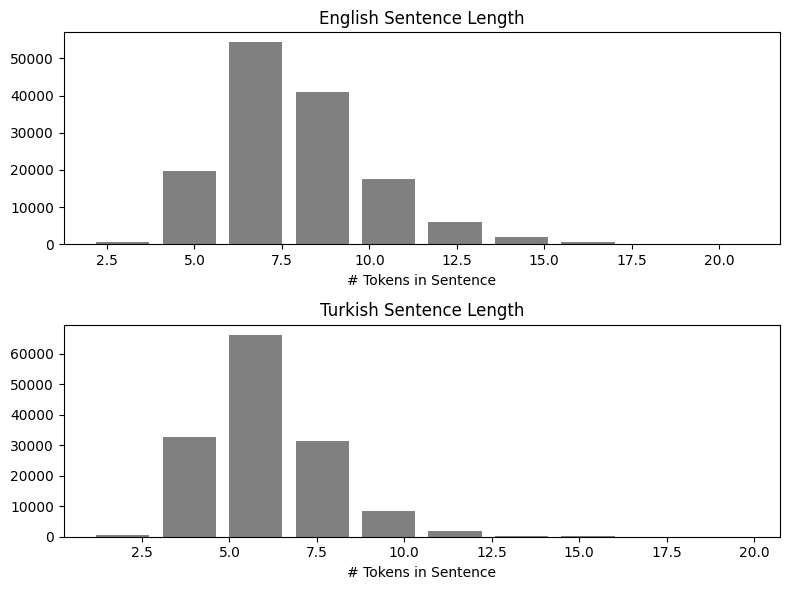

In [169]:
# İki alt grafik içeren bir figura oluştur
fig = plt.figure(figsize=(8, 6))

# İlk alt grafik (İngilizce cümle uzunlukları)
ax0 = fig.add_subplot(211)
ax0.hist(en_lengths, rwidth=0.8, color='gray')  # İngilizce cümle uzunluklarının histogramını çiz
ax0.set_title("English Sentence Length")  # Alt grafik başlığı
ax0.set_xlabel("# Tokens in Sentence")  # X ekseni etiketi

# İkinci alt grafik (Türkçe cümle uzunlukları)
ax1 = fig.add_subplot(212)
ax1.hist(tr_lengths, rwidth=0.8, color='gray')  # Türkçe cümle uzunluklarının histogramını çiz
ax1.set_title("Turkish Sentence Length")  # Alt grafik başlığı
ax1.set_xlabel("# Tokens in Sentence")  # X ekseni etiketi

# Grafikleri sıkıştır ve göster
plt.tight_layout()
plt.show()


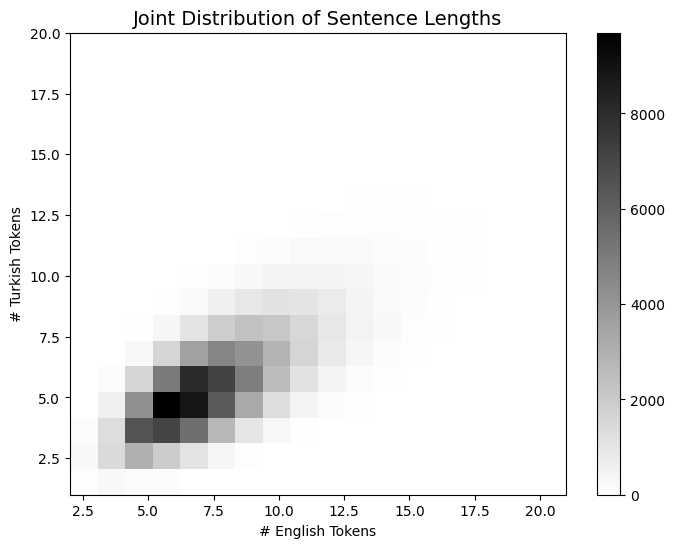

In [170]:
# Bir figure oluştur
plt.figure(figsize=(8, 6))

# 2D histogramı çiz
plt.hist2d(en_lengths, tr_lengths, bins=MAX_SENTENCE_LENGTH-2, cmap='binary')

# Grafik başlığı
plt.title("Joint Distribution of Sentence Lengths", fontsize=14)

# X ekseni etiketi
plt.xlabel("# English Tokens")

# Y ekseni etiketi
plt.ylabel("# Turkish Tokens")

# Renk skalası
plt.colorbar()

# Grafikleri göster
plt.show()


In [171]:
def plot_top_words(counter, k=20, ax=None):
    # En çok kullanılan k kelimeyi seç
    top_k = counter.most_common(k)
    
    # Kelimeleri ve frekanslarını ayrı listelere ayır
    words, freqs = zip(*reversed(top_k))
    
    # Eğer bir eksen belirtilmemişse, yatay bar grafiği çiz
    if ax is None:
        plt.barh(words, freqs, color='gray')
    else:
        # Eksen belirtilmişse, belirtilen eksen üzerine yatay bar grafiği çiz
        ax.barh(words, freqs, color='gray')


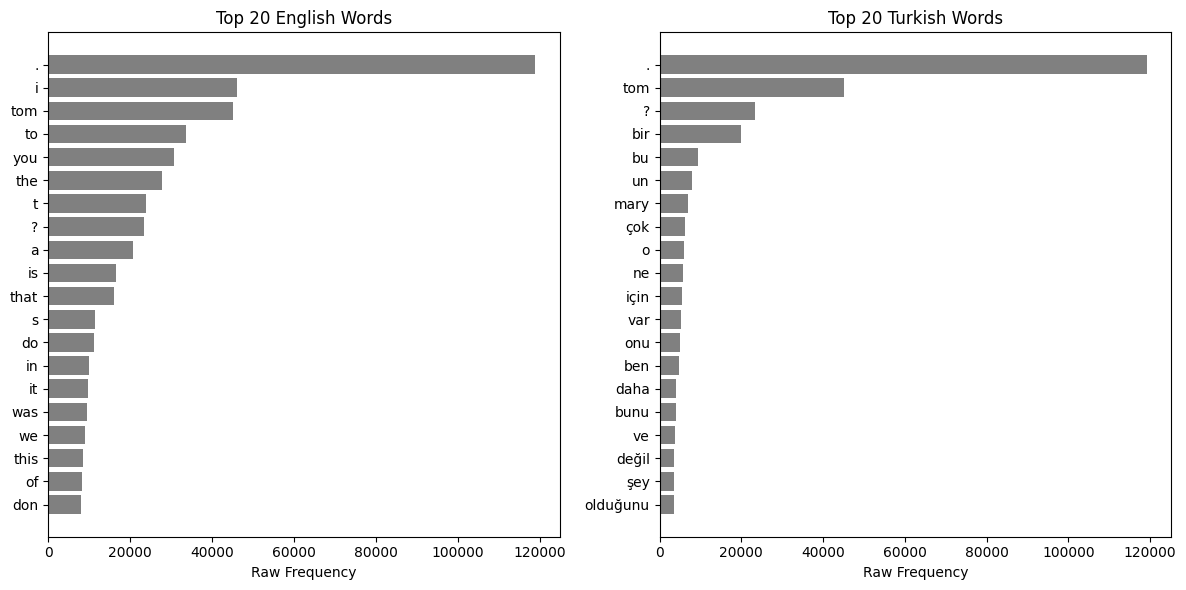

In [172]:
# Yeni bir figure (şekil) oluşturun ve boyutunu belirtin
fig = plt.figure(figsize=(12, 6))

# İlk subplot'u ekleyin (1 satır, 2 sütun, ve bu birinci subplot)
ax0 = fig.add_subplot(121)

# plot_top_words fonksiyonunu kullanarak ilk subplot'u doldurun
plot_top_words(en_counter, ax=ax0)

# İlk subplot'un başlığını ve x ekseni etiketini ayarlayın
ax0.set_title("Top 20 English Words")
ax0.set_xlabel("Raw Frequency")

# İkinci subplot'u ekleyin (1 satır, 2 sütun, ve bu ikinci subplot)
ax1 = fig.add_subplot(122)

# plot_top_words fonksiyonunu kullanarak ikinci subplot'u doldurun
plot_top_words(tr_counter, ax=ax1)

# İkinci subplot'un başlığını ve x ekseni etiketini ayarlayın
ax1.set_title("Top 20 Turkish Words")
ax1.set_xlabel("Raw Frequency")

# Subplotlar arasındaki boşluğu otomatik olarak ayarlayın
plt.tight_layout()

# Şekli gösterin
plt.show()


In [173]:
# Veri setini bölme oranları
VALID_PCT = 0.1
TEST_PCT = 0.1

# Boş veri setleri oluştur
train_data = []
valid_data = []
test_data = []

# Rastgele tohum belirleme
random.seed(6547)

# Her bir çifti işleme al
sayac = 0
for (en, tr) in formatted_pairs:
    # İngilizce ve Türkçe cümleleri tensor'a çevir
    en_tensor_ = torch.tensor([en_vocab[token] for token in tokenize_en(en)])
    tr_tensor_ = torch.tensor([tr_vocab[token] for token in tokenize_tr(tr)])
    
    # Rastgele bir sayı çek ve bölme oranlarına göre veri setlerine ekle
    random_draw = random.random()
    if random_draw <= VALID_PCT:
        valid_data.append((en_tensor_, tr_tensor_))
    elif random_draw <= VALID_PCT + TEST_PCT:
        test_data.append((en_tensor_, tr_tensor_))
    else:
        train_data.append((en_tensor_, tr_tensor_))
    
    sayac += 1
    
    # Her 1000 çift için ilerlemeyi ekrana yazdır
    if sayac % 1000 == 0:
        print(sayac)

# Bölünmüş veri seti boyutlarını ekrana yazdır
print(f"""
      Training pairs: {len(train_data):,}
      Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000

  Training pairs: 113,267
Validation pairs: 14,285
      Test pairs: 14,223


In [4]:
import pickle

# Değişkeni geri yükleme
with open('en_vocab.pkl', 'rb') as f:
    en_vocab = pickle.load(f)
    
with open('tr_vocab.pkl', 'rb') as f:
    tr_vocab = pickle.load(f)
    
# Özel token indekslerini belirle
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

In [179]:

# Özel token indekslerini belirle
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

# İki dilin özel tokenlerinin indekslerini karşılaştır ve eşit olup olmadığını kontrol et
for en_id, tr_id in zip(en_vocab.lookup_indices(SPECIALS), tr_vocab.lookup_indices(SPECIALS)):
    assert en_id == tr_id


In [180]:
def generate_batch(data_batch):
    '''
    Veri yığınlarını modelleme için hazırlar. Her bir örneğe BOS/EOS belirteçlerini ekler, tensörleri birleştirir
    ve daha kısa cümlelerin sonundaki boşlukları <pad> belirteci ile doldurur. 
    English-to-Turkish DataLoader'ında collate_fn olarak kullanılması amaçlanmıştır.

    Input:
    - data_batch, yukarıda oluşturulan veri setlerinden alınan (İngilizce, Türkçe) tuple'larını içeren bir iterasyon

    Output:
    - en_batch: İngilizce token ID'leri içeren (maksimum uzunluk X yığın boyutu) bir tensör
    - tr_batch: Türkçe token ID'leri içeren (maksimum uzunluk X yığın boyutu) bir tensör 
    '''
    
    en_batch, tr_batch = [], []
    
    for (en_item, tr_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        tr_batch.append(torch.cat([torch.tensor([BOS_IDX]), tr_item, torch.tensor([EOS_IDX])], dim=0))

    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    tr_batch = pad_sequence(tr_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, tr_batch


In [181]:
# Mini-batch boyutunu belirle
BATCH_SIZE = 16

# DataLoader ile eğitim, doğrulama ve test veri iteratörlerini oluştur
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)


In [185]:
# Eğitim veri iteratöründen örnekler al ve ekrana yazdır
for i, (en_id, tr_id) in enumerate(train_iter):
    print('English:', ' '.join([en_vocab.lookup_token(idx) for idx in en_id[:, 0]]))
    print('Turkish:', ' '.join([tr_vocab.lookup_token(idx) for idx in tr_id[:, 0]]))
    
    # İlk 5 mini-batch'i ekrana yazdıktan sonra döngüyü sonlandır
    if i == 4: 
        break
    else:
        print()


English: <bos> tom wants us to examine his case . <eos> <pad> <pad> <pad> <pad> <pad>
Turkish: <bos> tom dosyasını incelememizi istiyor . <eos> <pad> <pad> <pad> <pad>

English: <bos> tom s face was covered in bruises . <eos> <pad> <pad>
Turkish: <bos> tom un yüzü çürüklerle kaplıydı . <eos>

English: <bos> that noise is giving me a headache . <eos> <pad> <pad> <pad> <pad> <pad> <pad>
Turkish: <bos> o gürültü bana baş ağrısı veriyor . <eos> <pad> <pad> <pad> <pad> <pad>

English: <bos> three of them were hospitalized . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Turkish: <bos> onlardan üçü hastaneye yatırıldı . <eos> <pad> <pad> <pad> <pad> <pad>

English: <bos> can tom see us ? <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Turkish: <bos> tom bizi görebilir mi ? <eos> <pad> <pad> <pad>


In [ ]:
# Formate edilmiş çiftleri içeren değişkeni pickle formatında kaydetme
with open(os.path.join(datadir,'formatted_pairs.pkl'), 'wb') as f:
    pickle.dump(formatted_pairs, f)

# İngilizce kelime dağarcığını pickle formatında kaydetme
with open(os.path.join(datadir,'en_vocab.pkl'), 'wb') as f:
    pickle.dump(en_vocab, f)

# Türkçe kelime dağarcığını pickle formatında kaydetme
with open(os.path.join(datadir,'tr_vocab.pkl'), 'wb') as f:
    pickle.dump(tr_vocab, f)

# Eğitim veri setini pickle formatında kaydetme
with open(os.path.join(datadir,'train_data.pkl'), 'wb') as f:
    pickle.dump(train_data, f)
    
# Doğrulama veri setini pickle formatında kaydetme
with open(os.path.join(datadir,'valid_data.pkl'), 'wb') as f:
    pickle.dump(valid_data, f)

# Test veri setini pickle formatında kaydetme
with open(os.path.join(datadir,'test_data.pkl'), 'wb') as f:
    pickle.dump(test_data, f)

# Eğitim veri seti yükleyicisini pickle formatında kaydetme
with open(os.path.join(datadir,'train_iter.pkl'), 'wb') as f:
    pickle.dump(train_iter, f)

# Test veri seti yükleyicisini pickle formatında kaydetme
with open(os.path.join(datadir, 'test_iter.pkl'), 'wb') as f:
    pickle.dump(test_iter, f)

# Doğrulama veri seti yükleyicisini pickle formatında kaydetme
with open(os.path.join(datadir, 'valid_iter.pkl'), 'wb') as f:
    pickle.dump(valid_iter, f)


In [13]:
with open('ceviriler/en_vocab.pkl', 'rb') as f:
    en_vocab = pickle.load(f)    
    # Değişkeni geri yükleme
with open('ceviriler/tr_vocab.pkl', 'rb') as f:
    tr_vocab = pickle.load(f)
    

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_p=0.1, max_len=100):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, num_attention_heads, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, 
                 max_seq_length, pos_dropout, transformer_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(input_dim, d_model)
        self.embed_tgt = nn.Embedding(output_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)
        
        self.transformer = nn.Transformer(d_model, num_attention_heads, num_encoder_layers, 
                                          num_decoder_layers, dim_feedforward, transformer_dropout)
        self.output = nn.Linear(d_model, output_dim)
        
    def forward(self,
                src=None, 
                tgt=None,
                src_mask=None,
                tgt_mask=None, 
                src_key_padding_mask=None, 
                tgt_key_padding_mask=None,
                memory_key_padding_mask=None,
                src_embeds=None, 
                tgt_embeds=None):
        
        if (src_embeds is None) and (src is not None):
            if (tgt_embeds is None) and (tgt is not None):
                src_embeds, tgt_embeds = self._embed_tokens(src, tgt)
        elif (src_embeds is not None) and (src is not None):
            raise ValueError("Must specify exactly one of src and src_embeds")
        elif (src_embeds is None) and (src is None):
            raise ValueError("Must specify exactly one of src and src_embeds")
        elif (tgt_embeds is not None) and (tgt is not None):
            raise ValueError("Must specify exactly one of tgt and tgt_embeds")
        elif (tgt_embeds is None) and (tgt is None):
            raise ValueError("Must specify exactly one of tgt and tgt_embeds")
        
        output = self.transformer(src_embeds, 
                                  tgt_embeds, 
                                  tgt_mask=tgt_mask, 
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)
        
        return self.output(output)
    
    def _embed_tokens(self, src, tgt):
        src_embeds = self.embed_src(src) * np.sqrt(self.d_model)
        tgt_embeds = self.embed_tgt(tgt) * np.sqrt(self.d_model)
        
        src_embeds = self.pos_enc(src_embeds)
        tgt_embeds = self.pos_enc(tgt_embeds)
        return src_embeds, tgt_embeds

In [15]:
transformer = TransformerModel(input_dim=len(en_vocab), 
                             output_dim=len(tr_vocab), 
                             d_model=256, 
                             num_attention_heads=8,
                             num_encoder_layers=6, 
                             num_decoder_layers=6, 
                             dim_feedforward=2048,
                             max_seq_length=32,
                             pos_dropout=0.15,
                             transformer_dropout=0.3)

transformer = transformer.to("cpu")

C:\Users\VuralBayrakli\anaconda3\envs\env\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
def predict_transformer(text, model, 
                        src_vocab=en_vocab, 
                        src_tokenizer=tokenize_en, 
                        tgt_vocab=tr_vocab, 
                        device="cpu"):
    
    input_ids = [src_vocab[token.lower()] for token in src_tokenizer(text)]
    input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
    
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) 
        
        causal_out = torch.ones(MAX_SENTENCE_LENGTH, 1).long().to(device) * BOS_IDX
        for t in range(1, MAX_SENTENCE_LENGTH):
            decoder_output = transformer(input_tensor, causal_out[:t, :])[-1, :, :]
            next_token = decoder_output.data.topk(1)[1].squeeze()
            causal_out[t, :] = next_token
            if next_token.item() == EOS_IDX:
                break
                
        pred_words = [tgt_vocab.lookup_token(tok.item()) for tok in causal_out.squeeze(1)[1:(t)]]
        return " ".join(pred_words)

In [17]:
transformer.load_state_dict(torch.load("transformer_en_tr.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False

In [23]:
sentence = "The researchers were able to derive meaningful conclusions from the data."
predict_transformer(sentence, transformer)

'i i , yeni için için .'